# Compare Geocoders
Compare the performance of three geocoders(Bing, OpenStreetMap, Census) based on the **match rate**, the **mean absolute difference** in latitudes and longitudes and the **mean difference in distance**.
The input dataframe should follow certain rules. To use Bing and Nominatim, there should be a column called "full_address"(street address + city + state + zipcode). To use Census, there should be columns of street_address, city, state, zipcode separately. The output dataframe **DOES NOT** follow the same input order, so there should a column (called "unique_id") with a primary key or unique ID in the input dataframe to identify them.

In [1]:
import pandas as pd
import numpy as np
import geocoder
import os
import time
import seaborn as sns
import config.py
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

In [3]:
# read datasets to be geocoded
# df = pd.read_csv('data/BK_no_farm_or_vacant.csv', low_memory = False)
# focus1 = pd.read_csv('data/prob_subset_1_raw.csv', low_memory = False)
# focus2 = pd.read_csv('data/prob_subset_2_raw.csv', low_memory = False)
sub = pd.read_csv('data/subscriber_selected_proj.csv')

In [4]:
# format the input data
# column names should be ["unique_id", "street_address", "city", "state", "zipcode", "full_address", "latitude", "longitude"]
sub

,Project ID,Subscriber Type,Price,Period Start Date,Period End Date,Offering Type,Download Speed,Upload Speed,Address,City,State,Zipcode,Latitude,Longitude
0,IA1701-A61,Residence,49.95,1/1/2021,12/31/2021,Data,25,2.0,25572 Highway 12,Westfield,IA,51062.0,42.688900,-96.571960
1,IA1701-A61,Residence,59.95,1/1/2021,12/31/2021,Data,75,10.0,25754 Highway 12,Westfield,IA,51062.0,42.688900,-96.571960
2,IA1701-A61,Residence,32.95,1/1/2021,12/31/2021,Data/Voice,25,3.0,21601 N Ridge Rd,Westfield,IA,51062.0,42.717720,-96.524160
3,IA1701-A61,Residence,59.95,1/1/2021,12/31/2021,Data,75,10.0,23079 K18n,Westfield,IA,51062.0,42.717720,-96.524160
4,IA1701-A61,Residence,32.95,1/1/2021,12/31/2021,Data/Voice,25,2.0,23345 K18n,Westfield,IA,51062.0,42.717720,-96.524160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,ND1702-A59,Residence,57.95,1/1/2021,12/31/2021,Data,50,50.0,15207 77th St NE,Grafton,ND,58237.0,48.528158,-97.363528
1127,ND1702-A59,Residence,77.95,1/1/2021,12/31/2021,Data,100,100.0,7707 146th Ave NE,Grafton,ND,58237.0,48.529400,-97.491270
1128,ND1702-A59,Residence,76.50,1/1/2021,12/31/2021,Data/Video,100,100.0,7727 Highway 81,Grafton,ND,58237.0,48.532501,-97.451804
1129,ND1702-A59,Residence,67.95,1/1/2021,12/31/2021,Data/Voice/Video,100,100.0,14806 78th St NE,Grafton,ND,58237.0,48.542280,-97.446315


In [6]:
sub["full_address"] = sub["Address"] +', '+ sub["City"]+', ' + sub["State"]+', ' + sub["Zipcode"].astype(int).astype(str)

In [7]:
sub.sample(5)

,Project ID,Subscriber Type,Price,Period Start Date,Period End Date,Offering Type,Download Speed,Upload Speed,Address,City,State,Zipcode,Latitude,Longitude,full_address
68,IA1701-A61,Residence,59.95,1/1/2021,12/31/2021,Data/Voice/Video,75,10.0,21409 Cedar Ave,Westfield,IA,51062.0,42.744578,-96.552237,"21409 Cedar Ave, Westfield, IA, 51062"
415,MO1701-A60,Residence,59.95,1/1/2021,12/31/2021,Data,100,100.0,470 SW OAK LANE,Trenton,MO,64683.0,40.013440,-93.640990,"470 SW OAK LANE, Trenton, MO, 64683"
328,IA1701-A61,Residence,42.95,1/1/2021,12/31/2021,Data/Voice,75,10.0,48521 299th St,Hawarden,IA,51023.0,43.054255,-96.506234,"48521 299th St, Hawarden, IA, 51023"
1104,ND1702-A59,Residence,57.95,1/1/2021,12/31/2021,Data/Video,50,50.0,7413 149th Ave NE,Grafton,ND,58237.0,48.486492,-97.427072,"7413 149th Ave NE, Grafton, ND, 58237"
58,IA1701-A61,Residence,42.95,1/1/2021,12/31/2021,Data/Voice,75,10.0,19493 C44,Merrill,IA,51038.0,42.721827,-96.438935,"19493 C44, Merrill, IA, 51038"


In [10]:
sub_bing = Bing_single_queries(sub["full_address"])

In [11]:
sub_bing.to_csv("data/sub_bing.csv", index = False)

## Functions to run geocoders

### Bing

Single queries

In [9]:
def Bing_single_queries(addresses):
    # Requires: a list of full addresses to be geocoded
    # Returns: a dataframe of the coordinates and the confidence
    start_time = time.time()
    
    bing_coords = []
    bing_confidence = []
    for address in addresses:
        result = geocoder.bing(address, key = bing_api)
        bing_coords.append(result.latlng)
        bing_confidence.append(result.raw['confidence'])
        
    end_time = time.time()
    with open("Bing_single_time.txt", "a") as file:
        file.write("Sample size: " + str(len(addresses)) + '\n')
        file.write("Time: " + str(end_time - start_time) +"s"+ '\n')
        
    bing_coords_df = pd.DataFrame(data = bing_coords, columns = ['Bing_lat', 'Bing_lng'])
    bing_coords_df['Bing_confidence'] = bing_confidence
    
    return bing_coords_df

Batch queries (time cost is about the same)

In [3]:
def Bing_batch_queries(addresses):
    # Notes: need to modify the API to get the confidence
    counter = 0
    bing_coords = []
    #bing_confidence = []
    start_time = time.time()
    while counter < len(addresses):
        bing_addresses = addresses[counter : counter + 50]
        counter += 50
        g = geocoder.bing(bing_addresses, 
                          method = 'batch', 
                          key = bing_api)
        for result in g:
            bing_coords.append(result.latlng)
            #bing_confidence.append(result.raw['confidence'])
            
    end_time = time.time()
    with open("Bing_batch_time.txt", "a") as file:
        file.write("Sample size: " + str(len(addresses))+ '\n')
        file.write("Time: " + str(end_time - start_time) +"s"+ '\n')
        
    bing_coords_df = pd.DataFrame(data = bing_coords, columns = ['Bing_lat', 'Bing_lng'])
    #bing_coords_df['Bing_confidence'] = bing_confidence
    
    return bing_coords_df

### Nominatim

In [4]:
def Nominatim_single_queries(addresses):
    # Requires: a list of full addresses to be geocoded
    # Returns: a dataframe of the coordinates
    geolocator = Nominatim(user_agent = "UVA_BII", timeout = 5)
    search = RateLimiter(geolocator.geocode, min_delay_seconds = 1, max_retries = 1)
    
    start_time = time.time()
    
    nominatim_coords = []
    for address in addresses:
        result = search(address)
        try:
            nominatim_coords.append([result.latitude, result.longitude])
        except:
            nominatim_coords.append([np.nan, np.nan])
    
    end_time = time.time()
    with open("Nominatim_single_time.txt", "a") as file:
        file.write("Sample size: " + str(len(addresses))+ '\n')
        file.write("Time: " + str(end_time - start_time) +"s"+ '\n')
    
    nominatim_coords = pd.DataFrame(data = nominatim_coords, columns = ['Nominatim_lat', 'Nominatim_lng'])
    #print(nominatim_coords)
    return nominatim_coords

### Census

In [5]:
def Census_batch_queries(input_df, filename):
    # Requires: a dataframe with a primary key and separated address elements(street address, city, state, zip code) and a filename
    # Returns: a dataframe of the primary key, the coordinates and the match status (exact or not) and it will be outputed as filename_result.csv
    start_time = time.time()
    
    census_api_test = input_df[['unique_id', 'street_address', 'city', 'state', 'zipcode']]
    census_api_test.to_csv(filename + ".csv", index = False)
    os.system('curl --form "addressFile=@' + filename + '.csv" --form "benchmark=2020" https://geocoding.geo.census.gov/geocoder/locations/addressbatch --output ' + filename +'_result.csv')
    
    end_time = time.time()
    with open("Census_batch_time.txt", "a") as file:
        file.write("Sample size: " + str(len(input_df))+ '\n')
        file.write("Time: " + str(end_time - start_time) +"s"+ '\n')
    # read results
    sample_result = pd.read_csv(filename + "_result.csv", names = ["unique_id", "full_address_raw", "match_status", "exact_status", "full_address_api", "coordinates", "what?", "no_idea"])

    # split coordinates
    sample_result[['Census_lng', 'Census_lat']] = sample_result.coordinates.str.split(',', expand = True)
    census_coords = sample_result[['unique_id','Census_lat', 'Census_lng', 'exact_status']]
    #print(census_coords)
    return census_coords

### Run 3 Geocoders

In [6]:
def run_geocoders(input_df, filename):
    # Requires: 
    # Returns: 
    Bing_results = Bing_single_queries(input_df['full_address'])
    Nominatim_results = Nominatim_single_queries(input_df['full_address'])
    Census_results = Census_batch_queries(input_df, filename + "_census")
    
    results = input_df[["unique_id", "full_address", "Raw_lat", "Raw_lng"]].reset_index(drop = True)
    results = pd.concat([results, Bing_results, Nominatim_results], axis = 1)
    results = results.merge(Census_results, on = "dpid")
    results.to_csv("data/" + filename + ".csv", index = False)
    return results

In [7]:
def run_geocoders_2(input_df, filename):
    # Requires: 
    # Returns: 
    Bing_results = Bing_single_queries(input_df['full_address'])
    #Nominatim_results = Nominatim_single_queries(input_df['full_address'])
    Census_results = Census_batch_queries(input_df, filename + "_census")
    
    results = input_df[["unique_id", "full_address", "Raw_lat", "Raw_lng"]].reset_index(drop = True)
    results = pd.concat([results, Bing_results], axis = 1)
    results = results.merge(Census_results, on = "dpid")
    results.to_csv("data/" + filename + ".csv", index = False)
    return results

## Functions to Compare Results

In [8]:
def comp_match(res):
    Bing_fail = len(res[res.Bing_confidence != 'High'])
    Nominatim_fail = len(res[res.Nominatim_lat.isna()])
    Census_fail = len(res[res.Census_lat.isna()])
    
    Bing_match_rate = (len(res) - Bing_fail) / len(res)
    OSM_match_rate = (len(res) - Nominatim_fail) / len(res)
    Census_match_rate = (len(res) - Census_fail) / len(res)
    
    print("Bing Match rate: ", Bing_match_rate)
    print("Nominatim Match rate: ", OSM_match_rate)
    print("Census Match rate: ", Census_match_rate)

In [24]:
def comp_coords(res):
    full = res.dropna()
    #full = res
    full = full[full.Bing_confidence == 'High']
    
    full_lat = full[['Raw_lat', 'Bing_lat', 'Census_lat', 'Nominatim_lat']]
    full_lng = full[['Raw_lng', 'Bing_lng', 'Census_lng', 'Nominatim_lng']]
    def mean_diff(a, b):
        return np.mean(abs(a - b))
    
    lat_diff = full_lat.corr(method = mean_diff)
    lng_diff = full_lng.corr(method = mean_diff)
    
    # sns.heatmap(lat_diff, annot = True)
    # sns.heatmap(lng_diff, annot = True)
    
    print(lat_diff)
    print(lng_diff)

In [25]:
def comp_coords_dist(res):
    full = res.dropna()
    #full = res
    full = full[full.Bing_confidence == 'High']
    
    full_coords = pd.DataFrame(columns = ['Raw', 'Bing', 'Census', 'Nominatim', 'Raw_Bing', 'Raw_Census', 'Raw_OSM', 'Bing_Census', 'Bing_OSM', 'Census_OSM'])
    full_coords['Raw'] = list(zip(full.property_address_latitiude, full.property_address_longitude))
    full_coords['Bing'] = list(zip(full.Bing_lat, full.Bing_lng))
    full_coords['Census'] = list(zip(full.Census_lat, full.Census_lng))
    full_coords['Nominatim'] = list(zip(full.Nominatim_lat, full.Nominatim_lng))
    for i in range(0, len(full_coords)):
        full_coords.loc[i, 'Raw_Bing'] = float(geodesic(full_coords.loc[i, 'Raw'], full_coords.loc[i, 'Bing']).km)
        full_coords.loc[i, 'Raw_Census'] = float(geodesic(full_coords.loc[i, 'Raw'], full_coords.loc[i, 'Census']).km)
        full_coords.loc[i, 'Raw_OSM'] = float(geodesic(full_coords.loc[i, 'Raw'], full_coords.loc[i, 'Nominatim']).km)
        full_coords.loc[i, 'Bing_Census'] = float(geodesic(full_coords.loc[i, 'Bing'], full_coords.loc[i, 'Census']).km)
        full_coords.loc[i, 'Bing_OSM'] = float(geodesic(full_coords.loc[i, 'Bing'], full_coords.loc[i, 'Nominatim']).km)
        full_coords.loc[i, 'Census_OSM'] = float(geodesic(full_coords.loc[i, 'Census'], full_coords.loc[i, 'Nominatim']).km)
    #print(full_coords.info())
    #print(full_coords)
    dist_diff = full_coords[['Raw_Bing', 'Raw_Census', 'Raw_OSM', 'Bing_Census', 'Bing_OSM', 'Census_OSM']].astype(float)
    print("The mean difference in distance between the coordinates: ")
    print(dist_diff.describe())
    return full_coords
    

In [12]:
def comp_geocoders(filename):
    # requires: the filename of the result csv
    res = pd.read_csv("data/" + filename + ".csv")
    comp_match(res)
    comp_coords(res)
    dist_diff = comp_coords_dist(res)
    return dist_diff

Take a sample from the raw dataframe and compare the match rate and average distance differences for Nominatim, Census and Bing geocoders.

Comparison test (N = 500 from dataset with supposedly okay records)

In [12]:
df_ad = pd.read_csv("data/BK_no_prob_no_vacant.csv", low_memory = False)

In [13]:
test_n_500 = df_ad.sample(500)

In [14]:
test_res = run_geocoders(test_n_500, "test_2_n_500_no_prob")

In [26]:
comp_geocoders("test_2_n_500_no_prob")

Bing Match rate:  0.988
Nominatim Match rate:  0.714
Census Match rate:  0.84
                 BK_lat  Bing_lat  Census_lat  Nominatim_lat
BK_lat         1.000000  0.000178    0.000480       0.001095
Bing_lat       0.000178  1.000000    0.000532       0.001145
Census_lat     0.000480  0.000532    1.000000       0.000874
Nominatim_lat  0.001095  0.001145    0.000874       1.000000
                 BK_lng  Bing_lng  Census_lng  Nominatim_lng
BK_lng         1.000000  0.000157    0.000767       0.001649
Bing_lng       0.000157  1.000000    0.000747       0.001616
Census_lng     0.000767  0.000747    1.000000       0.001348
Nominatim_lng  0.001649  0.001616    0.001348       1.000000
The mean difference in distance between the coordinates: 
          BK_Bing   BK_Census      BK_OSM  Bing_Census    Bing_OSM  Census_OSM
count  304.000000  304.000000  304.000000   304.000000  304.000000  304.000000
mean     0.027547    0.094292    0.229142     0.099563    0.232076    0.194662
std      0.135693

,BK,Bing,Census,Nominatim,BK_Bing,BK_Census,BK_OSM,Bing_Census,Bing_OSM,Census_OSM
0,"(43.495166999999995, -96.688988)","(43.495128, -96.68898370000001)","(43.495052930000035, -96.68950589799994)","(43.49515129203157, -96.68951514482204)",0.00434693,0.0437644,0.0426728,0.0430527,0.0430628,0.0109538
1,"(43.535103, -96.835169)","(43.535115999999995, -96.83516429999999)","(43.53533584600007, -96.83483322399996)","(43.53525894949495, -96.83482336363636)",0.00149347,0.0374949,0.0328743,0.0362319,0.0318068,0.00858054
2,"(42.456821999999995, -96.3604)","(42.456821000000005, -96.360399)","(42.457686753000075, -96.36088350299995)","(42.457707586535705, -96.36077761188564)",0.000138222,0.103966,0.10316,0.1041,0.103291,0.00901221
3,"(42.577479, -96.32060200000001)","(42.577265000000004, -96.32058)","(42.57696283300004, -96.31983395699994)","(42.57734315, -96.320638999864)",0.0238406,0.0852265,0.0153935,0.0698432,0.00994113,0.0784413
4,"(39.795336999999996, -93.58130200000001)","(39.795333, -93.58130799999999)","(39.79492869200004, -93.58149142999996)","(39.79495526877445, -93.58137579844345)",0.000679211,0.0481505,0.0428526,0.0475603,0.0423399,0.010334
...,...,...,...,...,...,...,...,...,...,...
299,"(39.781769, -93.55739100000001)","(39.78176, -93.55739799999999)","(39.78151945600007, -93.55672739499994)","(39.781595587394115, -93.55677368804182)",0.00116539,0.0632405,0.0562782,0.0633524,0.0565114,0.00933694
300,"(43.342165, -96.304987)","(43.3421122, -96.30490390000001)","(43.34187680100007, -96.30449100199995)","(43.341954420409316, -96.3045473898518)",0.00893396,0.0514079,0.0426384,0.0424844,0.0338078,0.00976066
301,"(42.528494, -96.421102)","(42.528484999999996, -96.421092)","(42.528437233000034, -96.42049965999996)","(42.52852, -96.420603)",0.00129405,0.0498894,0.0411003,0.0489561,0.0403647,0.0125148
302,"(42.480298, -96.366945)","(42.480297, -96.366943)","(42.48051335400004, -96.36712183499998)","(42.480434, -96.367013)",0.000198452,0.0279944,0.0161087,0.0281748,0.0162704,0.0125612


In [31]:
comp_geocoders("test_1_n_500")

Bing Match rate:  0.984
Nominatim Match rate:  0.758
Census Match rate:  0.852
                 BK_lat  Bing_lat  Census_lat  Nominatim_lat
BK_lat         1.000000  0.000160    0.000603       0.001814
Bing_lat       0.000160  1.000000    0.000598       0.001824
Census_lat     0.000603  0.000598    1.000000       0.001575
Nominatim_lat  0.001814  0.001824    0.001575       1.000000
                 BK_lng  Bing_lng  Census_lng  Nominatim_lng
BK_lng         1.000000  0.000158    0.000623       0.002062
Bing_lng       0.000158  1.000000    0.000556       0.001978
Census_lng     0.000623  0.000556    1.000000       0.001721
Nominatim_lng  0.002062  0.001978    0.001721       1.000000
The mean difference in distance between the coordinates: 
          BK_Bing   BK_Census      BK_OSM  Bing_Census    Bing_OSM  Census_OSM
count  327.000000  327.000000  327.000000   327.000000  327.000000  327.000000
mean     0.024909    0.093832    0.319314     0.089846    0.317097    0.280646
std      0.12551

,BK,Bing,Census,Nominatim,BK_Bing,BK_Census,BK_OSM,Bing_Census,Bing_OSM,Census_OSM
0,"(42.383925, -96.990253)","(42.383917, -96.990251)","(42.38366538100007, -96.99030295599995)","(42.383741, -96.99019)",0.00090378,0.0291306,0.021087,0.0282756,0.0201853,0.0125334
1,"(47.920313, -97.443947)","(47.9198798, -97.44339079999999)","(47.91837277300005, -97.44677659599995)","(47.918612599999996, -97.3040112)",0.0636253,0.302105,10.4607,0.303509,10.4184,10.6707
2,"(42.823382, -96.557713)","(42.823389, -96.557711)","(42.82369515700003, -96.55787931099995)","(42.823617999999996, -96.55785418367348)",0.000794638,0.0373522,0.0286466,0.0366901,0.0280046,0.00881416
3,"(47.909302, -97.062462)","(47.9093003, -97.0624677)","(47.90949792300006, -97.06208435599994)","(47.90952282899354, -97.06220578829769)",0.000466152,0.0356589,0.0311405,0.0361119,0.0315524,0.00949076
4,"(40.389783, -93.583768)","(40.389784000000006, -93.583768)","(40.392896935000074, -93.58415400499996)","(40.39308085133375, -93.58405324861413)",0.000111042,0.347328,0.367001,0.347217,0.36689,0.0221417
...,...,...,...,...,...,...,...,...,...,...
322,"(47.896397, -97.085823)","(47.8964518, -97.0857723)","(47.89662289300003, -97.08679924299996)","(47.896547481198, -97.08683019134436)",0.00717623,0.0771982,0.0771485,0.0791104,0.0798155,0.00869839
323,"(43.07589, -96.774349)","(43.0758669, -96.7742179)","(43.07624450600008, -96.77399494799994)","(43.07621202121703, -96.77374024047863)",0.0109809,0.0488106,0.0611373,0.0457108,0.0546196,0.021055
324,"(42.809252, -95.96974)","(42.8092383, -95.9696667)","(42.80963898700003, -95.96933832699995)","(42.80961431068068, -95.9694427557189)",0.00618556,0.0541065,0.0470218,0.0519874,0.0456103,0.00897057
325,"(42.462226, -96.375263)","(42.462435, -96.3739482)","(42.46187939900005, -96.37187057899996)","(42.461857959183675, -96.37197406122448)",0.110604,0.281666,0.273583,0.181685,0.174564,0.00883822


In [22]:
dist_diff = comp_geocoders("test_2_n_500_no_prob")

Bing Match rate:  0.988
Nominatim Match rate:  0.714
Census Match rate:  0.84
                 BK_lat  Bing_lat  Census_lat  Nominatim_lat
BK_lat         1.000000  0.000564    0.000797       0.001073
Bing_lat       0.000564  1.000000    0.000797       0.001127
Census_lat     0.000797  0.000797    1.000000       0.000874
Nominatim_lat  0.001073  0.001127    0.000874       1.000000
                 BK_lng  Bing_lng  Census_lng  Nominatim_lng
BK_lng         1.000000  0.000632    0.001231       0.001632
Bing_lng       0.000632  1.000000    0.001060       0.001676
Census_lng     0.001231  0.001060    1.000000       0.001348
Nominatim_lng  0.001632  0.001676    0.001348       1.000000
The mean difference in distance between the coordinates: 
          BK_Bing  BK_Census  BK_OSM  Bing_Census  Bing_OSM  Census_OSM
count  494.000000        0.0     0.0          0.0       0.0         0.0
mean     0.096634        NaN     NaN          NaN       NaN         NaN
std      0.610006        NaN     NaN  

In [28]:
Bing_diff = dist_diff.BK_Bing

In [23]:
dist_diff[dist_diff.BK_Bing > 10]

,BK,Bing,Census,Nominatim,BK_Bing,BK_Census,BK_OSM,Bing_Census,Bing_OSM,Census_OSM
5,"(39.881741999999996, -93.795932)","(39.97458747, -93.79422047)",NaN,NaN,10.31,NaN,NaN,NaN,NaN,NaN


{'whiskers': [<matplotlib.lines.Line2D at 0x7f3537451220>,
 'caps': [<matplotlib.lines.Line2D at 0x7f35374518e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3537c57e80>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3537451fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f353745e280>],
 'means': []}

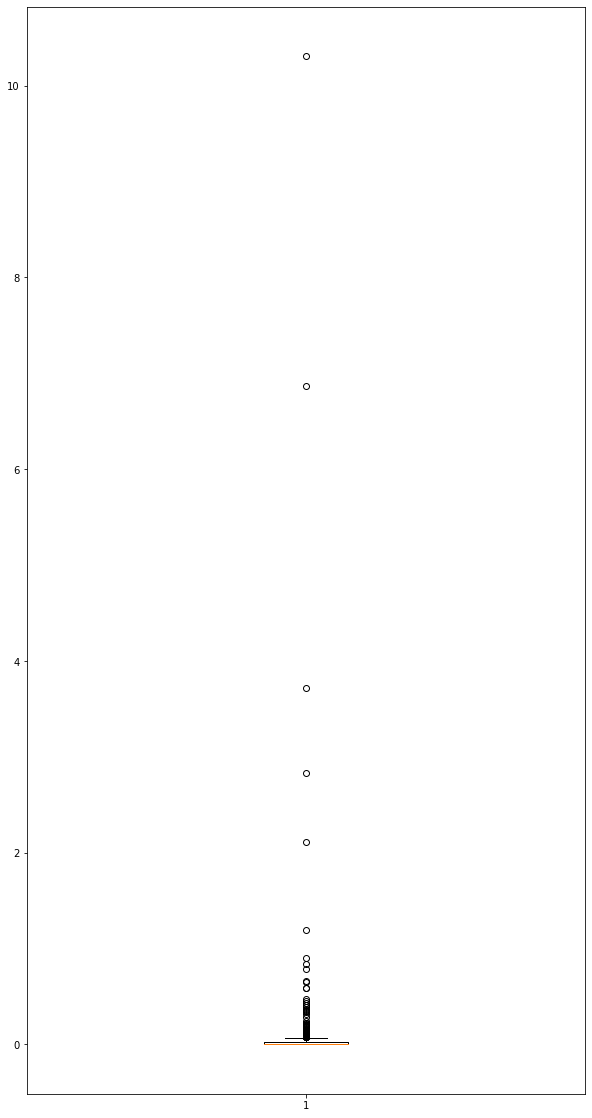

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,20))
plt.boxplot(Bing_diff)

Comparison test (N = 500 from problematic subsets)

In [62]:
test_prob_n_50 = pd.concat([focus1.sample(35),focus2.sample(15)])
test_prob_res = run_geocoders(test_prob_n_50, "test_prob_1_n_50")

In [74]:
comp_geocoders("test_prob_1_n_50")

Bing Match rate:  0.9428571428571428
Nominatim Match rate:  0.37142857142857144
Census Match rate:  0.6
                 BK_lat  Bing_lat  Census_lat  Nominatim_lat
BK_lat         1.000000  0.004959    0.004802       0.004603
Bing_lat       0.004959  1.000000    0.000887       0.001067
Census_lat     0.004802  0.000887    1.000000       0.000249
Nominatim_lat  0.004603  0.001067    0.000249       1.000000
                 BK_lng  Bing_lng  Census_lng  Nominatim_lng
BK_lng         1.000000  0.006962    0.006449       0.009004
Bing_lng       0.006962  1.000000    0.001342       0.014073
Census_lng     0.006449  0.001342    1.000000       0.012805
Nominatim_lng  0.009004  0.014073    0.012805       1.000000
The mean difference in distance between the coordinates: 
        BK_Bing  BK_Census    BK_OSM  Bing_Census  Bing_OSM  Census_OSM
count  7.000000   7.000000  7.000000     7.000000  7.000000    7.000000
mean   0.831742   0.773559  0.922238     0.171454  1.255438    1.106254
std    1.737

## Geocoding Problematic Records

Subset 1: Records with the same coordinates but different full addresses

In [64]:
run_geocoders_2(focus1, "prob_subset_1_result")

,dpid,full_address,property_address_latitiude,property_address_longitude,Bing_lat,Bing_lng,Bing_confidence,Census_lat,Census_lng,exact_status
0,191930019261,"1602 COLLEGE CT A, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474646,-96.357362,High,NaN,NaN,NaN
1,191930019262,"1602 COLLEGE CT B, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474642,-96.356886,High,NaN,NaN,NaN
2,191930019263,"1602 COLLEGE CT C, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474644,-96.357121,High,NaN,NaN,NaN
3,191930019264,"1602 COLLEGE CT D, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474642,-96.356886,High,NaN,NaN,NaN
4,191930019265,"1602 COLLEGE CT E, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474642,-96.356886,High,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3603,191930064065,"2515 INSIGNIA CIR, SIOUX CITY, IA, 51106",42.483800,-96.361300,42.465804,-96.306710,High,NaN,NaN,NaN
3604,191930064066,"2516 INSIGNIA CIR, SIOUX CITY, IA, 51106",42.483800,-96.361300,42.465839,-96.305961,High,NaN,NaN,NaN
3605,191930064086,"2710 ALBATROSS RDG, SIOUX CITY, IA, 51106",42.483800,-96.361300,42.462708,-96.309150,High,NaN,NaN,NaN
3606,191930064087,"2700 ALBATROSS RDG, SIOUX CITY, IA, 51106",42.483800,-96.361300,42.462978,-96.308815,High,NaN,NaN,NaN


In [78]:
nominatim_coords = Nominatim_single_queries(focus1["full_address"])

In [71]:
prob_subset_1_result = pd.read_csv("data/prob_subset_1_result.csv", index_col = [0])

In [72]:
prob_subset_1_result

,dpid,full_address,property_address_latitiude,property_address_longitude,Bing_lat,Bing_lng,Bing_confidence,Census_lat,Census_lng,exact_status
0,191930019261,"1602 COLLEGE CT A, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474646,-96.357362,High,NaN,NaN,NaN
1,191930019262,"1602 COLLEGE CT B, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474642,-96.356886,High,NaN,NaN,NaN
2,191930019263,"1602 COLLEGE CT C, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474644,-96.357121,High,NaN,NaN,NaN
3,191930019264,"1602 COLLEGE CT D, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474642,-96.356886,High,NaN,NaN,NaN
4,191930019265,"1602 COLLEGE CT E, SIOUX CITY, IA, 51106",42.474555,-96.357477,42.474642,-96.356886,High,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3603,191930064065,"2515 INSIGNIA CIR, SIOUX CITY, IA, 51106",42.483800,-96.361300,42.465804,-96.306710,High,NaN,NaN,NaN
3604,191930064066,"2516 INSIGNIA CIR, SIOUX CITY, IA, 51106",42.483800,-96.361300,42.465839,-96.305961,High,NaN,NaN,NaN
3605,191930064086,"2710 ALBATROSS RDG, SIOUX CITY, IA, 51106",42.483800,-96.361300,42.462708,-96.309150,High,NaN,NaN,NaN
3606,191930064087,"2700 ALBATROSS RDG, SIOUX CITY, IA, 51106",42.483800,-96.361300,42.462978,-96.308815,High,NaN,NaN,NaN


In [80]:
prob_subset_1_result = pd.concat([prob_subset_1_result, nominatim_coords], axis = 1)

In [81]:
prob_subset_1_result.to_csv("data/prob_subset_1_result.csv", index = False)

In [14]:
comp_geocoders("prob_subset_1_result")

Bing Match rate:  0.8586474501108647
Nominatim Match rate:  0.33647450110864746
Census Match rate:  0.5343680709534369
                 BK_lat  Bing_lat  Census_lat  Nominatim_lat
BK_lat         1.000000  0.004756    0.004080       0.008201
Bing_lat       0.004756  1.000000    0.001857       0.006105
Census_lat     0.004080  0.001857    1.000000       0.004731
Nominatim_lat  0.008201  0.006105    0.004731       1.000000
                 BK_lng  Bing_lng  Census_lng  Nominatim_lng
BK_lng         1.000000  0.010154    0.008420       0.009615
Bing_lng       0.010154  1.000000    0.003300       0.006819
Census_lng     0.008420  0.003300    1.000000       0.004074
Nominatim_lng  0.009615  0.006819    0.004074       1.000000
The mean difference in distance between the coordinates: 
          BK_Bing   BK_Census      BK_OSM  Bing_Census    Bing_OSM  Census_OSM
count  806.000000  806.000000  806.000000   806.000000  806.000000  806.000000
mean     1.075002    0.916948    1.404958     0.358567 

Subset 2: Records with the same addresses but different coordinates
For this subset, we drop records with duplicate addresses and then merge the results back into the dataframe on "full_address" since the geocoded coordinates will the same for the same address.

In [20]:
focus2_subset = focus2.drop_duplicates(subset = "full_address")

In [26]:
focus2_subset['dpid'] = focus2_subset['dpid'].astype(str)

<ipython-input-26-9d0cdba85139>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus2_subset['dpid'] = focus2_subset['dpid'].astype(str)


In [27]:
focus2_subset.dpid

0      191930027092
2      191930029370
3      191930031646
5      191930031920
7      191670011199
           ...     
617    191850000719
620    191930003789
622    191930005372
624    191930009348
626    191930013060
Name: dpid, Length: 342, dtype: object

In [28]:
prob_subset_2_res = run_geocoders(focus2_subset, "prob_subset_2_result")

In [29]:
comp_geocoders("prob_subset_2_result")

Bing Match rate:  0.9210526315789473
Nominatim Match rate:  0.4590643274853801
Census Match rate:  0.6812865497076024
                 BK_lat  Bing_lat  Census_lat  Nominatim_lat
BK_lat         1.000000  0.003519    0.003843       0.005825
Bing_lat       0.003519  1.000000    0.000821       0.003211
Census_lat     0.003843  0.000821    1.000000       0.002937
Nominatim_lat  0.005825  0.003211    0.002937       1.000000
                 BK_lng  Bing_lng  Census_lng  Nominatim_lng
BK_lng         1.000000  0.009824    0.010101       0.015144
Bing_lng       0.009824  1.000000    0.000972       0.006066
Census_lng     0.010101  0.000972    1.000000       0.005616
Nominatim_lng  0.015144  0.006066    0.005616       1.000000
The mean difference in distance between the coordinates: 
          BK_Bing   BK_Census      BK_OSM  Bing_Census    Bing_OSM  Census_OSM
count  111.000000  111.000000  111.000000   111.000000  111.000000  111.000000
mean     0.943703    0.989663    1.549311     0.134364  

In [31]:
prob_subset_2_res

,dpid,full_address,property_address_latitiude,property_address_longitude,Bing_lat,Bing_lng,Bing_confidence,Nominatim_lat,Nominatim_lng,Census_lat,Census_lng,exact_status
0,191930027092,"5411 PATTON ST, SIOUX CITY, IA, 51111",42.412197,-96.382351,42.413096,-96.393407,High,42.421752,-96.379821,42.41157365600003,-96.38603266799998,Non_Exact
1,191930029370,"2674 160TH ST, MOVILLE, IA, 51039",42.543165,-96.026649,42.474328,-96.082434,High,NaN,NaN,42.47495825900006,-96.08289491599999,Exact
2,191930031646,"110 E MAIN ST, LAWTON, IA, 51030",42.479468,-96.182971,42.479462,-96.183271,High,42.479666,-96.183556,NaN,NaN,NaN
3,191930031920,"2387 HIGHWAY 20, LAWTON, IA, 51030",42.475884,-96.136622,42.475867,-96.136239,High,42.475299,-96.201186,42.475078893000045,-96.13954563699997,Non_Exact
4,191670011199,"1187 7TH AVE NE, SIOUX CENTER, IA, 51250",43.090173,-96.166345,43.090196,-96.166361,High,43.088521,-96.165797,43.09015473200003,-96.16595932799999,Exact
...,...,...,...,...,...,...,...,...,...,...,...,...
337,191850000719,"804 N EATON AVE, HUMESTON, IA, 50123",40.865823,-93.497519,40.865728,-93.497803,High,40.866564,-93.498017,40.866465531000074,-93.49811897899997,Non_Exact
338,191930003789,"3014 HUMBOLT AVE, HORNICK, IA, 51026",42.269936,-96.077252,42.269138,-96.077928,High,NaN,NaN,42.26916471200008,-96.07770266399996,Exact
339,191930005372,"813 N SHANNON DR, SLOAN, IA, 51055",42.235805,-96.220364,42.235802,-96.220362,High,42.235615,-96.220734,NaN,NaN,NaN
340,191930009348,"2207 OLD HWY 141, BRONSON, IA, 51007",42.350175,-96.160395,42.358054,-96.172224,High,NaN,NaN,42.354943836000075,-96.17102768999996,Non_Exact


In [30]:
prob_subset_2_res_bing = prob_subset_2_res_bing[['full_address', 'Bing_lat', 'Bing_lng']]

NameError: name 'prob_subset_2_res_bing' is not defined

In [18]:
focus2.merge(prob_subset_2_res_bing, on = "full_address", how = "left")

,dpid,duplicateapn,full_address,property_full_street_address,property_city_name,property_state,property_zip_code,property_unit_type,property_unit_number,property_address_latitiude,property_address_longitude,property_address_census_tract,Bing_lat,Bing_lng
0,191490014872,NaN,"E NOTHEM AVE, REMSEN, IA, 51050",E NOTHEM AVE,REMSEN,IA,51050.0,NaN,NaN,42.817612,-95.968793,1.914997e+08,42.817144,-95.972117
1,191490031275,NaN,"E NOTHEM AVE, REMSEN, IA, 51050",E NOTHEM AVE,REMSEN,IA,51050.0,NaN,NaN,42.817328,-95.968793,1.914997e+08,42.817144,-95.972117
2,191930024842,NaN,"8TH ST, SERGEANT BLUFF, IA, 51054",8TH ST,SERGEANT BLUFF,IA,51054.0,NaN,NaN,42.407022,-96.362033,1.919300e+08,42.407466,-96.366003
3,191930024492,NaN,"1ST ST, SERGEANT BLUFF, IA, 51054",1ST ST,SERGEANT BLUFF,IA,51054.0,NaN,NaN,42.402481,-96.348021,1.919300e+08,42.397834,-96.361004
4,191930024749,NaN,"WOODFORD CT, SERGEANT BLUFF, IA, 51054",WOODFORD CT,SERGEANT BLUFF,IA,51054.0,NaN,NaN,42.405803,-96.364634,1.919300e+08,42.396046,-96.356728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,191930005373,NaN,"813 N SHANNON DR, SLOAN, IA, 51055",813 N SHANNON DR,SLOAN,IA,51055.0,NaN,NaN,42.235814,-96.220062,1.919300e+08,42.235802,-96.220362
2349,191930010879,NaN,"TAMA ST, SALIX, IA, 51052",TAMA ST,SALIX,IA,51052.0,NaN,NaN,42.309151,-96.285394,1.919300e+08,NaN,NaN
2350,191930010928,NaN,"TAMA ST, SALIX, IA, 51052",TAMA ST,SALIX,IA,51052.0,NaN,NaN,42.308127,-96.286451,1.919300e+08,NaN,NaN
2351,191930013060,NaN,"604 N 2ND AVE, ANTHON, IA, 51004",604 N 2ND AVE,ANTHON,IA,51004.0,NaN,NaN,42.393693,-95.866071,1.919300e+08,42.393694,-95.866076


## Merge the geocoded results into the raw dataframe

In [33]:
raw = pd.read_csv("data/BK_RAW_okay_records_no_vacant.csv", low_memory = False)

In [37]:
prob_subset_1_result = pd.read_csv("data/prob_subset_1_result.csv")
prob_subset_2_result = pd.read_csv("data/prob_subset_2_result.csv")

In [39]:
prob_subset_1_result_bing = prob_subset_1_result[prob_subset_1_result.Bing_confidence == "High"]

In [41]:
prob_subset_1_result_bing = prob_subset_1_result_bing[["dpid", "Bing_lat", "Bing_lng"]]

In [45]:
prob_subset_2_result_bing = prob_subset_2_result[prob_subset_2_result.Bing_confidence == "High"]

In [49]:
focus2_coded = focus2.merge(prob_subset_2_result, on = "full_address")

In [51]:
focus2_coded

,dpid_x,fips_code,pid,apn,duplicateapn,property_address_source_flag,property_full_street_address,property_city_name,property_state,property_zip_code,...,property_address_latitiude_y,property_address_longitude_y,Bing_lat,Bing_lng,Bing_confidence,Nominatim_lat,Nominatim_lng,Census_lat,Census_lng,exact_status
0,191930027092,19193,27199,884826200003,NaN,NaN,5411 PATTON ST,SIOUX CITY,IA,51111.0,...,42.412197,-96.382351,42.413096,-96.393407,High,42.421752,-96.379821,42.411574,-96.386033,Non_Exact
1,191930027094,19193,27201,884826200701,NaN,NaN,5411 PATTON ST,SIOUX CITY,IA,51111.0,...,42.412197,-96.382351,42.413096,-96.393407,High,42.421752,-96.379821,42.411574,-96.386033,Non_Exact
2,191930029370,19193,29471,894410100002,NaN,NaN,2674 160TH ST,MOVILLE,IA,51039.0,...,42.543165,-96.026649,42.474328,-96.082434,High,NaN,NaN,42.474958,-96.082895,Exact
3,191930014304,19193,14333,884504200002,NaN,C,2674 160TH ST,MOVILLE,IA,51039.0,...,42.543165,-96.026649,42.474328,-96.082434,High,NaN,NaN,42.474958,-96.082895,Exact
4,191930031646,19193,31772,894532405011,NaN,NaN,110 E MAIN ST,LAWTON,IA,51030.0,...,42.479468,-96.182971,42.479462,-96.183271,High,42.479666,-96.183556,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,191930005373,19193,5334,864629401010,NaN,C,813 N SHANNON DR,SLOAN,IA,51055.0,...,42.235805,-96.220364,42.235802,-96.220362,High,42.235615,-96.220734,NaN,NaN,NaN
625,191930009348,19193,9352,874614100001,NaN,NaN,2207 OLD HWY 141,BRONSON,IA,51007.0,...,42.350175,-96.160395,42.358054,-96.172224,High,NaN,NaN,42.354944,-96.171028,Non_Exact
626,191930061794,19193,59363,874614100012,NaN,NaN,2207 OLD HWY 141,BRONSON,IA,51007.0,...,42.350175,-96.160395,42.358054,-96.172224,High,NaN,NaN,42.354944,-96.171028,Non_Exact
627,191930013060,19193,13093,884332279001,NaN,NaN,604 N 2ND AVE,ANTHON,IA,51004.0,...,42.393693,-95.866071,42.393694,-95.866076,High,42.390132,-95.866439,42.393928,-95.866450,Non_Exact


In [52]:
focus2_coded = focus2_coded[["dpid_x", "Bing_lat", "Bing_lng"]]

In [53]:
focus2_coded.columns = ["dpid", "Bing_lat", "Bing_lng"]

In [55]:
focus2_coded['dpid'] = focus2_coded['dpid'].astype(str)

<ipython-input-55-4a4dd6b139d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus2_coded['dpid'] = focus2_coded['dpid'].astype(str)


In [58]:
prob_all_res = pd.concat([prob_subset_1_result_bing, focus2_coded])

In [59]:
prob_all_res

,dpid,Bing_lat,Bing_lng
0,191930019261,42.474646,-96.357362
1,191930019262,42.474642,-96.356886
2,191930019263,42.474644,-96.357121
3,191930019264,42.474642,-96.356886
4,191930019265,42.474642,-96.356886
...,...,...,...
624,191930005373,42.235802,-96.220362
625,191930009348,42.358054,-96.172224
626,191930061794,42.358054,-96.172224
627,191930013060,42.393694,-95.866076


In [61]:
raw_merged = raw.merge(prob_all_res, how = "left", on = "dpid")

In [62]:
raw_merged.to_csv("data/BK_RAW_no_vacant_geocoded.csv", index = False)